# Setup

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
from src import (get_data as gd, 
                 prepare as prep, 
                 aggregate_data as aggregate,
                 push_data,
                 sedi_rate,
                 age_sr_plot)
###
orig_dir = os.getcwd()

# Main Data

### Retrieve data 

In [2]:
dates = gd.AgeFromFileOneCore()

FileChooser(path='/home/jovyan/work/input_files', filename='', title='', show_hidden=False, select_desc='Selec…

Pleae select your file and then continue with the execution of the next cell.


In [3]:
dates.get_dates()

### Add calibration curve to data

In [4]:
dates.select_calibration_curve(default_curve = 'IntCal20', user_selection = False)

In [5]:
dates.add_calibration_curve()

### Put data in variables

In [6]:
AllAges = dates.all_ages
CoreIDs = dates.all_coreid_list
CoreLengths = dates.all_core_lengths
SR_mode = 'naive'

In [7]:
aggRC = lambda: None
aggRC.dttp = "No"

# Reservoir correction

#### Prep

In [8]:
os.chdir(orig_dir)
RC = prep.PrepForReservoirCorrection(all_ages = AllAges)
RC.prep_it()
RC_Frame = RC.RC_Frame
RC_CoreIDs = RC.RC_CoreIDs
RC_CoreLengths = CoreLengths[CoreLengths.coreid.isin(RC_CoreIDs)]

#### R run

In [9]:
%get RC_Frame
%get RC_CoreIDs 
%get RC_CoreLengths

In [10]:
K_fine <- 100

In [11]:
source('src/Run_DefineReservoir.R', local = TRUE)

Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Done with core number: 1 out of 1



In [12]:
%put reservoir_core_results

#### Aggregate results

In [13]:
aggRC = aggregate.AggDataReservoir(results = reservoir_core_results,
                                   surface_dates = RC.desired_surface_dates,
                                   verbose = 0)
aggRC.results_agg()

Reservoir value of 822 years and an error of 717 years was calculated for EN18208 


In [14]:
AllAges = aggRC.add_reservoir(all_ages = AllAges)

Would you like to add the reservoir values to all samples ('all'), to only bulk samples ('bulk'), or disregard the values ('without')?  without


# Calibration
#### Prep

In [15]:
calib = prep.PrepForCalibration(all_ages = AllAges)
calib.prep_it()
calib_Frame = calib.calib_Frame

#### R run

In [16]:
%get calib_Frame --from SoS

In [17]:
source('src/Run_calibration.R', local = TRUE)

In [18]:
%put calib_dates

# Age Modeling
### UNDATABLE
#### Prep

In [19]:
Undatable = prep.PrepForUndatable(all_ages = AllAges, 
                                  all_coreid_list = CoreIDs)
Undatable.prep_it()
CoreID_array = Undatable.CoreID_array

Information: New files for Undatable created!


#### Octave run

In [20]:
%get CoreID_array

In [21]:
xfactor = 0.1;
bootpc = 30;

In [22]:
run_Undatable(CoreID_array, xfactor, bootpc);

#### Aggregate results

In [23]:
aggU = aggregate.AggDataUndatable(Undatable, orig_dir, dttp = aggRC.dttp)
aggU.results_agg()

#### Calculate sedimentation rate

In [24]:
SRUn = sedi_rate.CalculateSediRate(aggU, model = 'Undatable', coreid = CoreIDs, mode = SR_mode)
SRUn.calculating_SR()

#### Push results to database

In [25]:
push = push_data.PushIt(agg = aggU,
                        engine = dates.engine,
                        model = 'Undatable')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


In [26]:
os.chdir(orig_dir)
push.delete_files(location_UndatableFolder = Undatable.location_UndatableFolder,
                  coreids = Undatable.coreid_df)

Information: All unwanted Undatable files have been deleted


### Bchron

#### Prep

In [27]:
os.chdir(orig_dir)
Bchron = prep.PrepForBchron(all_ages = AllAges)
Bchron.prep_it()
Bchron_Frame = Bchron.Bchron_Frame

#### R run

In [28]:
%get Bchron_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [29]:
source('src/Run_Bchron.R')

Some positionThicknesses are zero for identical positions. artificialThickness has been added so that the model can attempt to run. If the model still fails then increase the value of artificialThickness further.



Running Bchronology...
  |============================================================| 100%
Run completed!


 Done with core EN18208 - Number 1 out of 1



In [30]:
%put Bchron_core_results

#### Aggregate results

In [31]:
aggBc = aggregate.AggDataBchron(Bchron_core_results, dttp = aggRC.dttp)
aggBc.results_agg()

#### Calculating sedimentation rate

In [32]:
SRBc = sedi_rate.CalculateSediRate(aggBc, model = 'Bchron', coreid = CoreIDs, mode = SR_mode)
SRBc.calculating_SR()

#### Push results to database

In [33]:
push = push_data.PushIt(agg = aggBc,
                        engine = dates.engine,
                        model = 'Bchron')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


### hamstr

#### Prep

In [34]:
hamstr = prep.PrepForHamstr(all_ages = AllAges)
hamstr.prep_it()
hamstr_Frame = hamstr.hamstr_Frame

#### R Run

In [35]:
%get hamstr_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [36]:
K_fine <- 100

In [37]:
source('src/Run_hamstr.R', local = TRUE)

Warning message:
“There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Done with core: EN18208



In [38]:
%put hamstr_core_results

#### Aggregate

In [39]:
aggh = aggregate.AggDataHamstr(hamstr_core_results, dttp = aggRC.dttp)
aggh.results_agg()

#### Calculating sedimentation rate

In [40]:
SRh = sedi_rate.CalculateSediRate(aggh, model = 'hamstr', coreid = CoreIDs, mode = SR_mode)
SRh.calculating_SR()

#### Push results to database

In [41]:
push = push_data.PushIt(agg = aggh,
                        engine = dates.engine,
                        model = 'hamstr')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


### Bacon

#### Prep

In [42]:
Bacon = prep.PrepForBacon(all_ages = AllAges)
Bacon.prep_it()
Bacon_Frame = Bacon.Bacon_Frame

#### R Run

In [43]:
%get Bacon_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS
%get calib_dates --from SoS

In [44]:
acc.shape <- 1.5
acc.mean <- 20
mem.strength <- 10
mem.mean <- 0.5
ssize <- 10000
rbacon.change.acc.mean <- TRUE
rbacon.change.thick <- TRUE

In [45]:
source('src/Run_Bacon.R', local = TRUE)

starting worker for localhost:11443 
Type: EXEC 
Type: EXEC 


Loading required package: foreach
Loading required package: rngtools
Running Bacon for core EN18208 (attempt 1)
 Using calibration curve specified within the .csv file,0

Adapting acc.mean to 50 yr/cm
 Setting thick to 10



The run's files will be put in this folder: /tmp/RtmpZI1v2x/EN18208
Reading /tmp/RtmpZI1v2x/EN18208/EN18208_107.bacon
Constant calibration curve.
IntCal20: Reading from file: /opt/conda/lib/R/library/rintcal/extdata/3Col_intcal20.14C
Marine20: Reading from file: /opt/conda/lib/R/library/rintcal/extdata/3Col_marine20.14C
SHCal20: Reading from file: /opt/conda/lib/R/library/rintcal/extdata/3Col_shcal20.14C
Added det: EN18208: 2232.2+-69.8   d=16 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18208: 4294.1+-86.0   d=36 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18208: 6343.9+-52.6   d=56 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18208: 7389.2+-60.2   d=76 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18208: 9831.0+-143.2  d=104 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18208: 11419.9+-125.2  d=124 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18208: 13026.7+-71.4   d

 Will run 38,150,000 iterations and store 10,000


twalk: 8617984 iterations so far
Will finish in approx. 1 minutes and 46 seconds.
twalk: 25838592 iterations so far
Will finish in approx. 43 seconds.
twalk: Finished,  0.3% of moved pars per iteration (ratio 131634.788989/38150000). Output in file /tmp/RtmpZI1v2x/EN18208/EN18208_107.out,
      Sun May 18 20:33:46 2025

Writing two last points of the twalk in /tmp/RtmpZI1v2x/EN18208/EN18208_107.bacon.last.
bacon: 7 WarnBeyondLimits warnings:
bacon: WARNING: calibration attempted beyond MinYr= -75.000000 or MaxYr= 10000000.000000
bacon: burn in (initial iterations which will be removed): 8175000
Eso es to...eso es to...eso es to...eso es toooodo amigos!


Warning, this will take quite some time to calculate. I suggest increasing d.by to, e.g., 10

Calculating age ranges...


  |=                                                                     |   2%


Preparing ghost graph... 


  |======================================================================| 100%


Mean 95% confidence ranges 1962 yr, min. 303 yr at 57 cm, max. 7640 yr at 1076 cm
Warning! Only 72% of the dates overlap with the age-depth model (95% ranges)
Posteriors: accrate mean 40.27, shape 0.54, memory mean 0.49, strength 11.45
⏳ Extracting ages at 1077 depths × 10000 iterations
✅ Done with core EN18208


Type: DONE 


In [46]:
%put Bacon_core_results

There were 50 or more warnings (use warnings() to see the first 50)


#### Aggregate

In [47]:
aggBa = aggregate.AggDataBacon(Bacon_core_results, dttp = aggRC.dttp)
aggBa.results_agg()

#### Calculating sedimentation rate

In [48]:
SRBa = sedi_rate.CalculateSediRate(aggBa, model = 'Bacon', coreid = CoreIDs, mode = SR_mode)
SRBa.calculating_SR()

#### Push results to database

In [49]:
push = push_data.PushIt(agg = aggBa,
                        engine = dates.engine,
                        model = 'Bacon')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


### Clam

#### Prep

In [50]:
clam = prep.PrepForClam(all_ages = AllAges)
clam.prep_it()
clam_Frame = clam.clam_Frame

#### R Run

In [51]:
%get clam_Frame --from SoS
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [52]:
types_curve <- 1:5
smoothness_curve <- 0.1*(1:10)
poly_degree_curve <- 1:4
best_fit <- TRUE

In [53]:
source('src/Run_clam.R', local = TRUE)

🌍 Starting core EN18208 (1 of 1)



starting worker for localhost:11443 
starting worker for localhost:11443 
starting worker for localhost:11443 
starting worker for localhost:11443 
starting worker for localhost:11443 
starting worker for localhost:11443 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 


⚠️ Excluding clam type 3 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 1 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.1 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.2 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 2 degree 1 for EN18208 due to NA or infinite fit value


Type: EXEC 


⚠️ Excluding clam type 2 degree 2 for EN18208 due to NA or infinite fit value


Type: EXEC 


⚠️ Excluding clam type 2 degree 3 for EN18208 due to NA or infinite fit value


Type: EXEC 


⚠️ Excluding clam type 2 degree 4 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.3 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.4 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.5 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.6 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.7 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.8 for EN18208 due to NA or infinite fit value


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 0.9 for EN18208 due to NA or infinite fit value


Type: EXEC 


⚠️ Excluding clam type 4 smoothing 1.0 for EN18208 due to NA or infinite fit value


Type: EXEC 


⚠️ Excluding clam type 5 smoothing 0.2 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 5 smoothing 0.4 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 5 smoothing 0.3 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 5 smoothing 0.5 for EN18208 due to age reversal warning


Type: EXEC 


⚠️ Excluding clam type 5 smoothing 0.6 for EN18208 due to age reversal warning
⚠️ Excluding clam type 5 smoothing 0.1 for EN18208 due to age reversal warning
⚠️ Excluding clam type 5 smoothing 0.7 for EN18208 due to age reversal warning
⚠️ Excluding clam type 5 smoothing 0.8 for EN18208 due to age reversal warning
⚠️ Excluding clam type 5 smoothing 0.9 for EN18208 due to age reversal warning
⚠️ Excluding clam type 5 smoothing 1.0 for EN18208 due to NA or infinite fit value


Type: DONE 
Type: DONE 
Type: DONE 
Type: DONE 
Type: DONE 
Type: DONE 


In [54]:
%put clam_core_results

#### Aggregate

In [55]:
aggcl = aggregate.AggDataClam(clam_core_results, dttp = aggRC.dttp)
aggcl.results_agg()

No age data available!


#### Calculating sedimentation rate

In [56]:
SRcl = sedi_rate.CalculateSediRate(aggcl, model = 'clam', coreid = CoreIDs, mode = SR_mode)
SRcl.calculating_SR()

No sedimentation rate data available!


#### Push results to database

In [57]:
push = push_data.PushIt(agg = aggcl,
                        engine = dates.engine,
                        model = 'clam')
push.push_to_db()

Information: The result list was empty, so nothing was uploaded.


# Plotting

In [58]:
plot_data = {'Undatable' : [aggU.age_model_result_Undatable, SRUn.SR_model_result_Undatable],
             'Bchron': [aggBc.age_model_result_Bchron, SRBc.SR_model_result_Bchron],
             'hamstr': [aggh.age_model_result_hamstr, SRh.SR_model_result_hamstr],
             'Bacon': [aggBa.age_model_result_Bacon, SRBa.SR_model_result_Bacon],
             'clam': [aggcl.age_model_result_clam, SRcl.SR_model_result_clam],
             'calib_dates': calib_dates}

In [59]:
ASRplot = age_sr_plot.PlotAgeSR(plot_data, coreid = CoreIDs, dttp = aggRC.dttp)

Note: clam cannot be added to plot


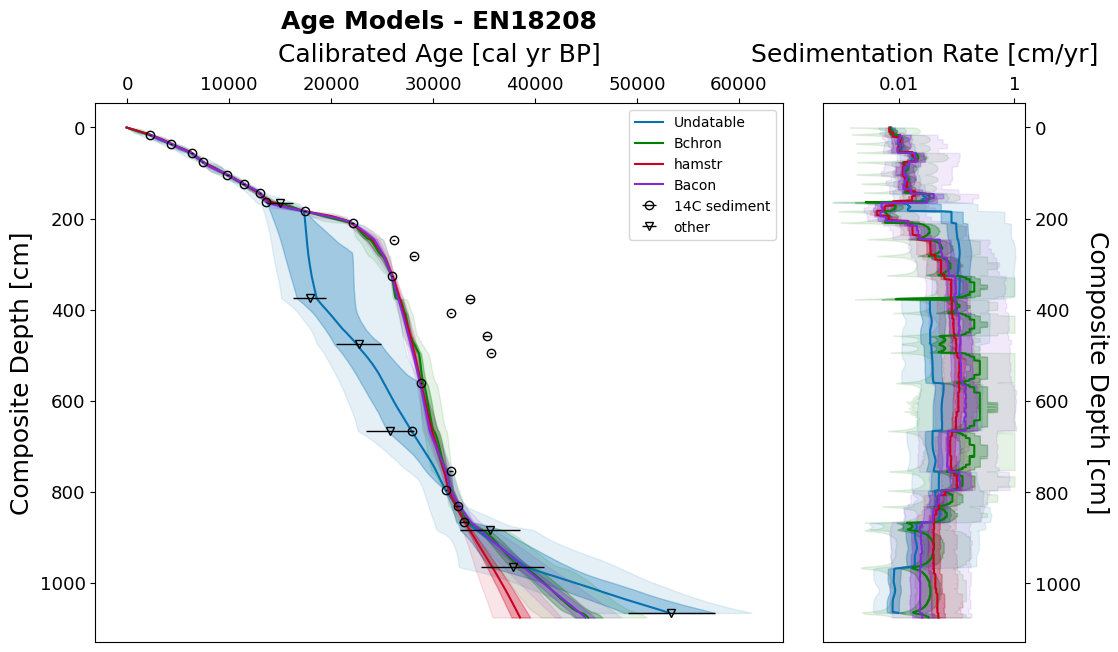

In [60]:
ASRplot.plot_graph(orig_dir = orig_dir, sigma_range = 'both',
                   bin_size = 1000, xlim_max = 21000, number_col = 8, reduce_plot_axis = True,
                   only_combined = False, save = False, for_color_blind = False, as_jpg = False)

# Optimization

In [61]:
proxy = gd.ProxyFromFile()

FileChooser(path='/home/jovyan/work/input_files', filename='', title='', show_hidden=False, select_desc='Selec…

Pleae select your file and then continue with the execution of the next cell.


In [63]:
proxy_ts = proxy.get_proxy()
###
dict_model_name = ASRplot.dict_model_name
dict_SR_median_age = ASRplot.dict_SR_median_age

In [64]:
%get dict_SR_median_age --from SoS
%get dict_model_name --from SoS
%get proxy_ts --from SoS

In [65]:
curr_nreps     <- 1000
curr_minseg    <- 50
curr_cptmethod <- "mean+variance"

In [66]:
source('src/Run_Optimization.R', local = TRUE)

In [67]:
%put result_list 
%put fitting_values

In [81]:
from importlib import reload
reload(age_sr_plot)

<module 'src.age_sr_plot' from '/home/jovyan/work/src/age_sr_plot.py'>

In [82]:
optimizedASRplot = age_sr_plot.PlotAgeSR(plot_data, coreid = CoreIDs, dttp = aggRC.dttp)

Note: clam cannot be added to plot


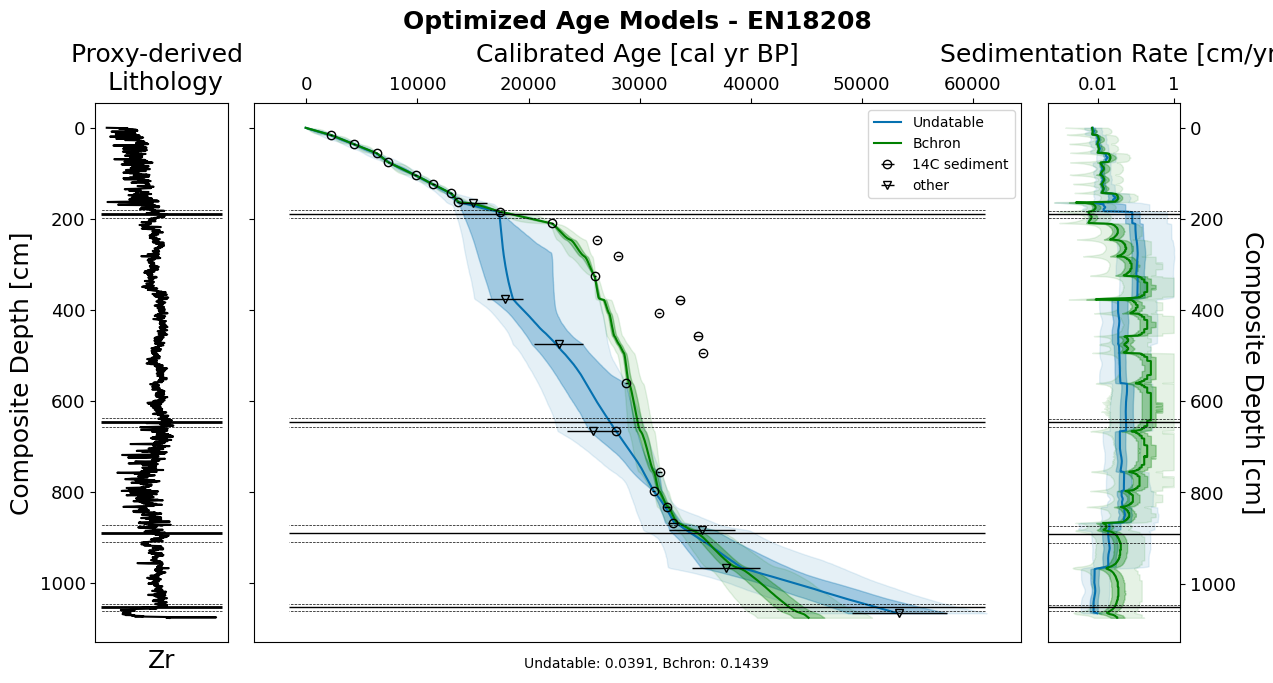

In [83]:
optimizedASRplot.plot_optimized_graph(optimization_values = result_list, fitting_values = fitting_values, 
                                      proxy = proxy.name, proxy_data = proxy_ts, orig_dir = orig_dir, 
                                      sigma_range = 'both', inclusion_threshold = 0.03, show_fitting_models = True,
                                      bin_size = 1000, xlim_max = 21000, number_col = 8, reduce_plot_axis = True,
                                      only_combined = False, save = False, for_color_blind = False, as_jpg = False)